In [1]:
import geopandas as gpd
import pandas as pd


from pathlib import Path

current_path = Path.cwd().parent
print(current_path)

/home/nissim/Documents/dev/ciut-inundaciones


In [2]:
USE_CRS = "EPSG:5349"

In [18]:
dat = gpd.read_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/la_plata_pelig_2023_datos_originales.geojson"
)
dat = dat.to_crs(USE_CRS)

In [19]:
dat.shape

(39, 10)

In [20]:
dat.head()

,ID,H,V,H*V,PELIGROSID,fid,Hmax,Vmax,id,geometry
0,2500.0,1.573,0.101,0.159,alta,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((7118520.266 6099642.316, 71185..."
1,1130.0,0.492,0.233,0.115,baja,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((7116435.381 6103307.189, 71164..."
2,1224.0,0.511,0.196,0.100,media,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((7115136.442 6105172.006, 71151..."
3,NaN,1.524,0.193,0.294,alta,10180.0,NaN,NaN,NaN,"MULTIPOLYGON (((7130721.934 6088195.784, 71307..."
4,NaN,0.294,0.346,0.102,baja,1043.0,NaN,NaN,NaN,"MULTIPOLYGON (((7131086.596 6085421.208, 71310..."


<Axes: >

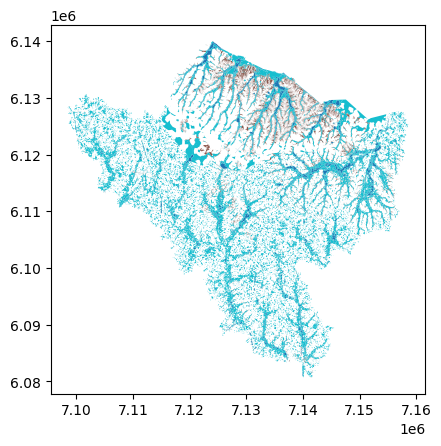

In [21]:
dat.plot("PELIGROSID")

In [22]:
# convert column names to lowercase
dat.columns = dat.columns.str.lower()

# filter out rows where peligrosid is 'muy baja a nula'
dat = dat[dat["peligrosid"] != "Muy Baja a Nula"]

<Axes: >

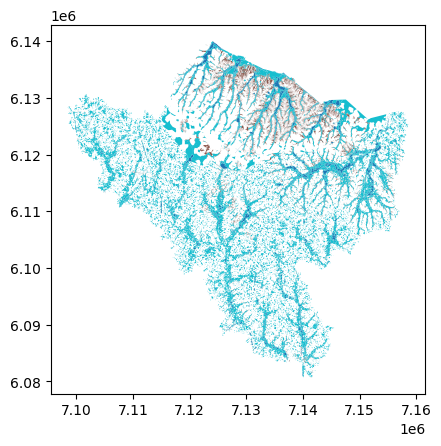

In [23]:
dat.plot("peligrosid")

In [24]:
import rasterio
from rasterio import features
import numpy as np
from shapely.geometry import shape

# Define the target raster properties
bounds = dat.total_bounds  # (minx, miny, maxx, maxy)
resolution = 2.5  # meters - adjust as needed
width = int(np.ceil((bounds[2] - bounds[0]) / resolution))
height = int(np.ceil((bounds[3] - bounds[1]) / resolution))
iterations = 1

# Create a mapping from peligrosid values to numeric codes
peligrosid_mapping = {"alta": 3, "media": 2, "baja": 1}

# Create the raster
raster = np.zeros((height, width), dtype=np.uint8)

# Get the transform - corrected function call
transform = rasterio.transform.from_bounds(
    west=bounds[0],
    south=bounds[1],
    east=bounds[2],
    north=bounds[3],
    width=width,
    height=height,
)

# Rasterize the polygons
shapes = (
    (shape(geom), peligrosid_mapping.get(val, 0))
    for geom, val in zip(dat.geometry, dat["peligrosid"])
)

rasterized = features.rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,  # Fill nodata areas with 0
    dtype=np.uint8,
)

In [25]:
# After rasterization, identify edge pixels
from scipy import ndimage

# Find edges using morphological operations
edge_mask = ndimage.binary_dilation(rasterized > 0) ^ ndimage.binary_erosion(
    rasterized > 0
)

# Apply random perturbations to edge pixels only
perturbed = rasterized.copy()
edge_coords = np.where(edge_mask)

for i in range(len(edge_coords[0])):
    row, col = edge_coords[0][i], edge_coords[1][i]

    # Random chance to flip this edge pixel
    if np.random.random() < 0.3:  # 30% chance
        # Randomly choose a neighboring pixel's value
        neighbors = rasterized[max(0, row - 1) : row + 2, max(0, col - 1) : col + 2]
        neighbor_values = neighbors[neighbors > 0]
        if len(neighbor_values) > 0:
            perturbed[row, col] = np.random.choice(neighbor_values)

import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon

shapes_gen = rasterio.features.shapes(
    perturbed, mask=perturbed > 0, transform=transform
)
df = pd.DataFrame(shapes_gen, columns=["geometry", "value"])

# Vectorized operations
df["geometry"] = df["geometry"].apply(shape)
df["peligrosid"] = df["value"].map({1: "baja", 2: "media", 3: "alta"})

# Create GeoDataFrame
gdf_perturbed = gpd.GeoDataFrame(df[["geometry", "peligrosid"]], crs=dat.crs)

In [26]:
from grass_session import Session
import geopandas as gpd
import tempfile
import os

# Create temporary files
with tempfile.NamedTemporaryFile(suffix=".geojson", delete=False) as input_temp:
    input_path = input_temp.name
with tempfile.NamedTemporaryFile(suffix=".geojson", delete=False) as output_temp:
    output_path = output_temp.name

try:
    # Save GeoPandas to temp file
    gdf_perturbed.to_file(input_path, driver="GeoJSON")

    # GRASS processing - remove existing location first
    import shutil

    location_path = "grassdata/temp_location"
    if os.path.exists(location_path):
        shutil.rmtree(location_path)

    with Session(
        gisdb="grassdata",
        location="temp_location",
        create_opts=f"EPSG:{gdf_perturbed.crs.to_epsg()}",
    ) as session:
        import grass.script as gscript

        # Import your perturbed data
        gscript.run_command(
            "v.in.ogr", input=input_path, output="perturbed", overwrite=True
        )

        # Clean and snap the polygons before smoothing
        gscript.run_command(
            "v.clean",
            input="perturbed",
            output="cleaned_polygons",
            tool="rmdupl,rmdangle,rmbridge,rmarea",
            overwrite=True,
        )

        gscript.run_command(
            "v.clean",
            input="cleaned_polygons",
            output="cleaned_polygons_snapped",
            tool="snap",
            threshold=0.1,
            overwrite=True,
        )

        gscript.run_command("v.build", map="cleaned_polygons_snapped")

        # Apply Chaiken smoothing
        gscript.run_command(
            "v.generalize",
            input="cleaned_polygons_snapped",
            output="smoothed",
            method="chaiken",
            iterations=6,
            threshold=10,
            overwrite=True,
        )

        # Delete output files if they exist (GeoJSON driver doesn't overwrite)
        if os.path.exists(output_path):
            os.unlink(output_path)
        output_path_uncategorized = output_path.replace(
            ".geojson", "_uncategorized.geojson"
        )
        if os.path.exists(output_path_uncategorized):
            os.unlink(output_path_uncategorized)

        # Export smoothed result (categorized features only)
        gscript.run_command(
            "v.out.ogr", input="smoothed", output=output_path, format="GeoJSON"
        )

    # Read the smoothed result back into GeoPandas
    gdf_smoothed = gpd.read_file(output_path)

finally:
    # Clean up temp files
    os.unlink(input_path)
    os.unlink(output_path)
    output_path_uncategorized = output_path.replace(
        ".geojson", "_uncategorized.geojson"
    )
    if os.path.exists(output_path_uncategorized):
        os.unlink(output_path_uncategorized)

Check if OGR layer <tmpcyeysbf8> contains polygons...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Creating attribute table for layer <tmpcyeysbf8>...
Importing 63500 features (OGR layer <tmpcyeysbf8>)...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
-----------------------------------------------------
Registering primitives...
-----------------------------------------------------700     800     900    1000    1100    1200    1300    1400    1500    1600
Cleaning polygons
-----------------------------------------------------
Breaking polygons...
Breaking polygons (pass 1: select break points)...
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37 

In [34]:
from shapely.geometry import MultiPolygon

gdf_buffered = gdf_smoothed.copy()  # or gdf_smooth1 if you reduced smoothing
gdf_buffered["geometry"] = gdf_buffered["geometry"].buffer(2 * resolution)  # buffer out
gdf_buffered["geometry"] = gdf_buffered["geometry"].buffer(
    -2 * resolution
)  # buffer back


def ensure_multipolygon(geom):
    """Convert geometry to MultiPolygon type."""
    if geom is None or geom.is_empty:
        return None

    if isinstance(geom, MultiPolygon):
        return geom
    elif isinstance(geom, Polygon):
        return MultiPolygon([geom])
    elif hasattr(geom, "geoms"):  # GeometryCollection
        polygons = []
        for g in geom.geoms:
            if isinstance(g, Polygon):
                polygons.append(g)
            elif isinstance(g, MultiPolygon):
                polygons.extend(list(g.geoms))
        if polygons:
            return MultiPolygon(polygons)
    return None


# Step 1: Separate by hazard level
gdf_high = gdf_buffered[gdf_buffered["peligrosid"] == "alta"].copy()
gdf_medium = gdf_buffered[gdf_buffered["peligrosid"] == "media"].copy()
gdf_low = gdf_buffered[gdf_buffered["peligrosid"] == "baja"].copy()

# Step 2: Dissolve each by hazard to create unified geometries
high_union = gdf_high.dissolve(by="peligrosid") if not gdf_high.empty else None
medium_union = gdf_medium.dissolve(by="peligrosid") if not gdf_medium.empty else None
low_union = gdf_low.dissolve(by="peligrosid") if not gdf_low.empty else None

# Step 3: Remove overlaps according to priority (high > medium > low)
priority_geometries = []

# High priority areas (no clipping needed)
if high_union is not None:
    high_geom = ensure_multipolygon(high_union.union_all())
    if high_geom is not None:
        gdf_high_final = gpd.GeoDataFrame(geometry=[high_geom], crs=gdf_buffered.crs)
        gdf_high_final["peligrosid"] = "alta"
        priority_geometries.append(gdf_high_final)
else:
    high_geom = None

# Medium priority areas (clip out high areas)
if medium_union is not None:
    if high_geom is not None:
        medium_diff = medium_union.union_all().difference(high_geom)
    else:
        medium_diff = medium_union.union_all()

    medium_geom = ensure_multipolygon(medium_diff)
    if medium_geom is not None:
        gdf_medium_final = gpd.GeoDataFrame(
            geometry=[medium_geom], crs=gdf_buffered.crs
        )
        gdf_medium_final["peligrosid"] = "media"
        priority_geometries.append(gdf_medium_final)
        # Keep original union for next step
        medium_geom_original = ensure_multipolygon(medium_union.union_all())
    else:
        medium_geom_original = None
else:
    medium_geom_original = None

# Low priority areas (clip out both high and medium areas)
if low_union is not None:
    low_diff = low_union.union_all()
    if high_geom is not None:
        low_diff = low_diff.difference(high_geom)
    if medium_geom_original is not None:
        low_diff = low_diff.difference(medium_geom_original)

    low_geom = ensure_multipolygon(low_diff)
    if low_geom is not None:
        gdf_low_final = gpd.GeoDataFrame(geometry=[low_geom], crs=gdf_buffered.crs)
        gdf_low_final["peligrosid"] = "baja"
        priority_geometries.append(gdf_low_final)

# Step 4: Combine all priority levels
if priority_geometries:
    gdf_priority = gpd.GeoDataFrame(
        pd.concat(priority_geometries, ignore_index=True), crs=gdf_buffered.crs
    )

    # Convert to WGS84 for export
    gdf_priority = gdf_priority.to_crs(epsg=4326)

    # Export the priority-corrected hazard zones
    gdf_priority.to_parquet("peligrosid_priority_corrected_full_partido.parquet")
    print("Priority-corrected hazard zones created and exported!")
    print(f"Final GeoDataFrame contains {len(gdf_priority)} hazard levels")
else:
    print("No hazard zones found in the buffered data")

/tmp/ipykernel_56642/3959519829.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buffered['geometry'] = gdf_buffered['geometry'].buffer(2 * resolution) # buffer out
/tmp/ipykernel_56642/3959519829.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buffered['geometry'] = gdf_buffered['geometry'].buffer(-2 * resolution) # buffer back


Priority-corrected hazard zones created and exported!
Final GeoDataFrame contains 3 hazard levels


In [37]:
gdf_smoothed = gdf_smoothed.to_crs("epsg:4326")

In [38]:
gdf_smoothed.to_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/la_plata_pelig_2023_smoothed_w_double_buffer_out_and_back.geojson",
    driver="GeoJSON",
)

In [34]:
from io import BytesIO
from owslib.wfs import WebFeatureService

In [48]:
def wfs_to_gdf(wfs_url: str, layer_name: str, srs: str = "EPSG:4326", bbox_geom=None, max_features=None) -> gpd.GeoDataFrame:
    """
    Descarga una capa WFS y la devuelve como GeoDataFrame.
    
    Args:
        wfs_url (str): URL del servicio WFS.
        layer_name (str): Nombre de la capa (typename).
        srs (str): Código EPSG del sistema de referencia de coordenadas.
        bbox_geom: Geometría para calcular el bbox (GeoDataFrame o geometría). Opcional.
        max_features (int): Número máximo de features por request. None para usar el default del servidor.
    
    Returns:
        gpd.GeoDataFrame: Capa descargada como GeoDataFrame.
    """
    from io import BytesIO
    from owslib.wfs import WebFeatureService
    import pandas as pd
    import xml.etree.ElementTree as ET
    import requests
    from urllib.parse import urlencode
    
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    
    # Preparar parámetros base
    base_params = {
        'typename': layer_name,
        'srsname': srs
    }
    
    # Agregar bbox si se proporciona
    bbox_param = None
    if bbox_geom is not None:
        if hasattr(bbox_geom, 'crs') and bbox_geom.crs != srs:
            bbox_geom_proj = bbox_geom.to_crs(srs)
        else:
            bbox_geom_proj = bbox_geom
            
        if hasattr(bbox_geom_proj, 'total_bounds'):
            bounds = bbox_geom_proj.total_bounds
        else:
            bounds = bbox_geom_proj.bounds
        
        bbox_tuple = (bounds[0], bounds[1], bounds[2], bounds[3], srs)
        base_params['bbox'] = bbox_tuple
        bbox_param = f"{bounds[0]},{bounds[1]},{bounds[2]},{bounds[3]},{srs}"
    
    # Si no se especifica max_features, intentar obtener todo con paginación
    if max_features is None:
        # Primero obtener el conteo total usando request directo
        try:
            count_params = {
                'service': 'WFS',
                'version': '2.0.0',
                'request': 'GetFeature',
                'typename': layer_name,
                'resultType': 'hits',
                'srsname': srs
            }
            
            if bbox_param:
                count_params['bbox'] = bbox_param
            
            count_url = f"{wfs_url}?{urlencode(count_params)}"
            print(f"DEBUG: Count URL: {count_url}")
            
            count_response = requests.get(count_url)
            print(f"DEBUG: HTTP Status: {count_response.status_code}")
            
            count_response.raise_for_status()
            
            print(f"DEBUG: Response content length: {len(count_response.content)}")
            print(f"DEBUG: First 500 chars of response:")
            print(count_response.text[:500])
            print("=" * 50)
            
            # Parsear XML para obtener el número total
            root = ET.fromstring(count_response.content)
            
            # Debug: mostrar la estructura XML
            print(f"DEBUG: Root tag: {root.tag}")
            print(f"DEBUG: Root attributes: {root.attrib}")
            
            # Buscar el atributo numberOfFeatures
            total_features = None
            for elem in root.iter():
                print(f"DEBUG: Element tag: {elem.tag}, attributes: {elem.attrib}")
                if 'numberOfFeatures' in elem.attrib:
                    total_features = int(elem.attrib['numberOfFeatures'])
                    print(f"DEBUG: Found numberOfFeatures: {total_features}")
                    break
            
            if total_features is not None:
                page_size = 1000
                total_pages = (total_features + page_size - 1) // page_size  # Ceiling division
                print(f"Total features to download: {total_features}")
                print(f"Estimated pages: {total_pages} (page size: {page_size})")
            else:
                print("DEBUG: Could not find numberOfFeatures attribute in any element")
                print("Could not determine total feature count, proceeding with pagination...")
                
        except Exception as e:
            print(f"DEBUG: Exception type: {type(e).__name__}")
            print(f"DEBUG: Exception message: {str(e)}")
            import traceback
            print(f"DEBUG: Full traceback:")
            traceback.print_exc()
            print("Proceeding with pagination without total count...")
            total_features = None
        
        # Proceder con la descarga paginada
        all_gdfs = []
        start_index = 0
        page_size = 1000
        
        while True:
            params = base_params.copy()
            params['startindex'] = start_index
            params['maxfeatures'] = page_size
            
            try:
                response = wfs.getfeature(**params)
                gdf_page = gpd.read_file(BytesIO(response.read()))
                
                if gdf_page.empty:
                    break
                    
                # Establecer el CRS si no está definido
                if gdf_page.crs is None:
                    gdf_page = gdf_page.set_crs(srs)
                
                all_gdfs.append(gdf_page)
                
                # Mostrar progreso
                current_total = sum(len(g) for g in all_gdfs)
                if total_features:
                    progress = (current_total / total_features) * 100
                    print(f"Page {len(all_gdfs)}/{total_pages}: {len(gdf_page)} features | Total: {current_total}/{total_features} ({progress:.1f}%)")
                else:
                    print(f"Page {len(all_gdfs)}: {len(gdf_page)} features | Total so far: {current_total}")
                
                # Si obtuvimos menos features que el page_size, es la última página
                if len(gdf_page) < page_size:
                    break
                    
                start_index += page_size
                
            except Exception as e:
                print(f"Error downloading page starting at {start_index}: {e}")
                break
        
        if all_gdfs:
            gdf = pd.concat(all_gdfs, ignore_index=True)
            print(f"Download complete! Total features: {len(gdf)}")
        else:
            # Crear GeoDataFrame vacío con CRS
            gdf = gpd.GeoDataFrame(geometry=[], crs=srs)
            
    else:
        # Descarga simple con límite específico
        params = base_params.copy()
        params['maxfeatures'] = max_features
        
        response = wfs.getfeature(**params)
        gdf = gpd.read_file(BytesIO(response.read()))
        
        if gdf.crs is None:
            gdf = gdf.set_crs(srs)
    
    return gdf

In [49]:
# Test manual: obtener las coordenadas de La Plata
la_plata_5347 = la_plata.to_crs("EPSG:5347")
bounds = la_plata_5347.total_bounds
print(f"La Plata bounds in EPSG:5347: {bounds}")

# Probar con bbox manual
catastro = wfs_to_gdf(
    wfs_url="https://geo.arba.gov.ar/geoserver/idera/wfs",
    layer_name="idera:Parcela",
    srs="EPSG:5347",
    bbox_geom=la_plata
)

La Plata bounds in EPSG:5347: [5656205.85 6099505.91 5705190.99 6217586.14]
DEBUG: Count URL: https://geo.arba.gov.ar/geoserver/idera/wfs?service=WFS&version=2.0.0&request=GetFeature&typename=idera%3AParcela&resultType=hits&srsname=EPSG%3A5347&bbox=5656205.85%2C6099505.909999998%2C5705190.990000001%2C6217586.139999999%2CEPSG%3A5347
DEBUG: HTTP Status: 200
DEBUG: Response content length: 840
DEBUG: First 500 chars of response:
<?xml version="1.0" encoding="UTF-8"?><wfs:FeatureCollection xmlns:xs="http://www.w3.org/2001/XMLSchema" xmlns:fes="http://www.opengis.net/fes/2.0" xmlns:wfs="http://www.opengis.net/wfs/2.0" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:ows="http://www.opengis.net/ows/1.1" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" next="https://geo.arba.gov.ar/geoserver/idera/wfs?TYPENAME=idera%3AParcela&amp;RESULTTYPE=results&amp;REQUEST=GetFeature&amp;B
DEBUG: Root tag: {http://www.opengis.net/wfs/2.0}FeatureCollection
DE

KeyboardInterrupt: 

In [27]:
catastro.head()

,gml_id,cca,tpa,ara1,sag,pda,geometry
0,Parcela.05511000000000000000000000000000000000...,055110000000000000000000000000000000001000,Urbano,1862592.39,ARBA,055355517,"MULTIPOLYGON (((5661426.39 6217582.45, 5661432..."
1,Parcela.086020B0000000000000000010000000000000...,086020B0000000000000000010000000000000700C,Rural,15764.81,ARBA,086263339,"MULTIPOLYGON (((5659511.14 6160439.13, 5659415..."
2,Parcela.086020B0000000000000000010000000000000...,086020B0000000000000000010000000000000100D,Rural,135747.66,ARBA,086147156,"MULTIPOLYGON (((5659160.81 6160671.14, 5658792..."
3,Parcela.086020B0000000000000000010000000000000...,086020B0000000000000000010000000000000100E,Rural,79476.32,ARBA,086088612,"MULTIPOLYGON (((5658573.59 6160737.05, 5658766..."
4,Parcela.086020G0000000000000000010000000000000...,086020G0000000000000000010000000000000100F,Rural,166035.73,ARBA,086086876,"MULTIPOLYGON (((5658205.09 6161305.39, 5657864..."


In [17]:
# Ejemplo de uso:
partidos = wfs_to_gdf(
     wfs_url="https://geo.arba.gov.ar/geoserver/idera/wfs",
     layer_name="idera:Departamento",
     srs="EPSG:5347"
)

partidos = partidos.to_crs(USE_CRS)

In [18]:
la_plata = partidos[partidos['fna'] == 'Partido de La Plata']

In [20]:
la_plata.crs

<Projected CRS: EPSG:5349>
Name: POSGAR 2007 / Argentina 7
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Argentina - east of 55°30'W, onshore.
- bounds: (-55.5, -28.11, -53.65, -25.49)
Coordinate Operation:
- name: Argentina zone 7
- method: Transverse Mercator
Datum: Posiciones Geodesicas Argentinas 2007
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
catastro = wfs_to_gdf(
     wfs_url="https://geo.arba.gov.ar/geoserver/idera/wfs",
     layer_name="idera:Parcela",
     srs="EPSG:5347",
    bbox_geom=la_plata
)

catastro = catastro.to_crs(USE_CRS)

In [23]:
catastro.shape

(0, 7)

In [11]:
peligro = gpd.read_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/la_plata_pelig_2023_smoothed_w_buffer.geojson"
)
peligro = peligro.to_crs(USE_CRS)

In [9]:
peligro = peligro.to_crs("epsg:4326")

peligro.to_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/la_plata_pelig_2023_final.geojson",
    driver="GeoJSON",
)